# Libraries and Data

In [1]:
# Install the chronos library and time series database
!pip install -q git+https://github.com/amazon-science/chronos-forecasting.git
!pip install -q tsdb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.1 MB/s eta 0:00:00


In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

import tsdb
from chronos import ChronosPipeline
from datetime  import datetime
import torch

In [ ]:
# Load the Data from TSDB library
# Air quality data of sites in beijing
df = pd.DataFrame(tsdb.load('beijing_multisite_air_quality')['X'])
df.head()

2024-08-17 16:52:49 [INFO]: You're using dataset beijing_multisite_air_quality, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/beijing_multisite_air_quality
2024-08-17 16:52:49 [INFO]: Start downloading...
2024-08-17 16:52:50 [INFO]: Successfully downloaded data to /tmp/tmp9c815a8g/PRSA2017_Data_20130301-20170228.zip
2024-08-17 16:52:50 [INFO]: Successfully extracted data to /root/.pypots/tsdb/beijing_multisite_air_quality
2024-08-17 16:52:50 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv, data shape (35064, 18)
2024-08-17 16:52:50 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-20170228.csv, data shape (35064, 18)
2024-08-17 16:52:50 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-20170

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


In [ ]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 61.0+ MB


In [ ]:
# Rename the 'TEMP' column as 'y'
df = df.rename(columns = {'TEMP': 'y'})
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,y,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


In [ ]:
# Function to create a datetime variable from year, month, day, and hour columns
def clean_datetime(df):
  dttime = str(df['year']) + "-" + str(df['month']) + "-" + str(df['day']) + " " + str(df['hour']) + ":00:00"
  return datetime.strptime(dttime, '%Y-%m-%d %H:%M:%S')


# Apply the function to create a new datetime column 'ds'
df['ds'] = df.apply(clean_datetime, axis = 1)
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,y,PRES,DEWP,RAIN,wd,WSPM,station,ds
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan,2013-03-01 00:00:00
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan,2013-03-01 01:00:00
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan,2013-03-01 02:00:00
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan,2013-03-01 04:00:00


In [ ]:
# Set the 'ds' column as the index of the dataframe
df = df.set_index('ds')
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,y,PRES,DEWP,RAIN,wd,WSPM,station
ds,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Dongsi
2013-03-01 01:00:00,2,2013,3,1,1,4.0,4.0,3.0,16.0,300.0,88.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Dongsi
2013-03-01 02:00:00,3,2013,3,1,2,7.0,7.0,NaN,17.0,300.0,60.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Dongsi
2013-03-01 03:00:00,4,2013,3,1,3,3.0,3.0,5.0,18.0,NaN,NaN,-1.4,1026.2,-25.5,0.0,N,4.9,Dongsi
2013-03-01 04:00:00,5,2013,3,1,4,3.0,3.0,7.0,NaN,200.0,84.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Dongsi


In [ ]:
# Zooming in on Wanliu
# Filter the dataframe to include only the data from the 'Wanliu' station and select the 'y' column
df = df.loc[df["station"] == "Wanliu"]["y"]
df.head()

,y
ds,
2013-03-01 00:00:00,-0.7
2013-03-01 01:00:00,-1.1
2013-03-01 02:00:00,-1.1
2013-03-01 03:00:00,-1.4
2013-03-01 04:00:00,-2.0


In [ ]:
# Set the frequency of the DataFrame to hourly
df = df.asfreq("H")

# Exploratory Data Analysis

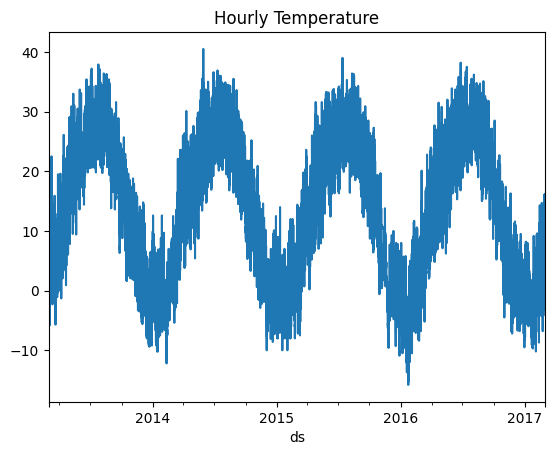

In [ ]:
# Plot the hourly temperature data
df.plot(title = 'Hourly Temperature')
plt.show()

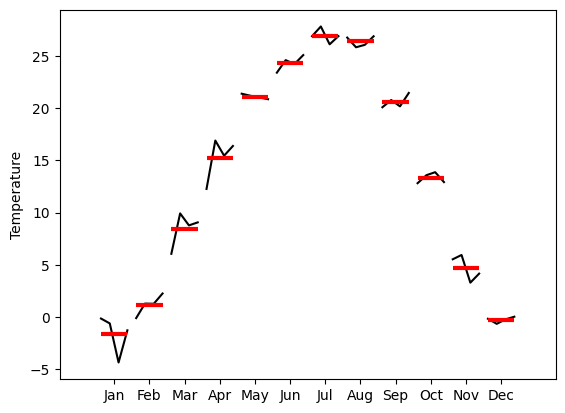

In [ ]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of temperature
month_plot(df.resample('M').mean(),
           ylabel = 'Temperature')
plt.show()

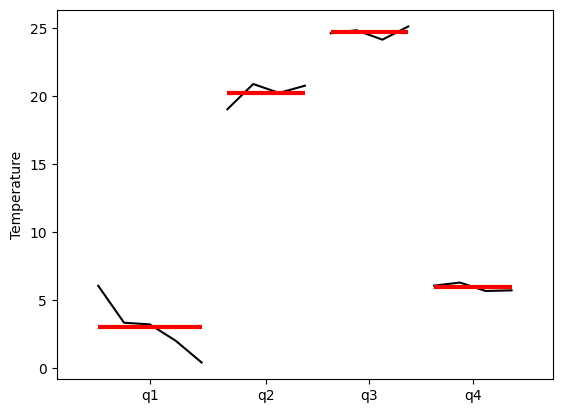

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of temperature
quarter_plot(df.resample('Q').mean(),
           ylabel = 'Temperature')
plt.show()

In [ ]:
# There is an hourly seasonality in the data

# Amazon Chronos Model

In [ ]:
# Start a pipeline from the pretrained model using ChronosPipeline
# amazon/chronos-t5-large
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
# Print the documentation for the 'predict' method in ChronosPipeline
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            

In [ ]:
# Build the forecast using the ChronosPipeline's predict method
forecast = pipeline.predict(
    context=torch.tensor(df),          # Pass the time series data as a tensor
    temperature=1.0,                   # Set the sampling temperature for prediction
    top_k=50,                          # Limit the number of highest probability vocabulary tokens to keep for top-k-filtering
    top_p=1.0,                         # Set the cumulative probability for nucleus sampling
    prediction_length=72,              # Define the number of steps to predict into the future
    num_samples=20,                    # Specify the number of samples to generate
    limit_prediction_length=False      # Allow predictions longer than the context size
)

<ipython-input-16-812df2189503>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = pipeline.predict(context = torch.tensor(df),
/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [ ]:
# Get the forecasts by calculating the mean of the predicted samples
forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim = 0)
forecast_mean

tensor([ 6.8013,  6.3973,  6.0943,  5.9932,  5.1852,  4.7138,  3.6027,  3.6027,
         6.1953,  8.7879, 11.0101, 12.3905, 13.6027, 14.5454, 14.7811, 14.7138,
        14.0404, 13.1986, 12.0875, 10.9091,  9.5959,  8.8215,  8.3501,  8.6532,
         7.0033,  5.8922,  4.9158,  3.9057,  4.0067,  4.1077,  3.9057,  3.9057,
         4.9158,  7.8114,  9.4612, 11.4478, 12.7609, 13.2660, 13.9730, 13.4680,
        13.4680, 12.5926, 10.8080,  8.5858,  6.4983,  4.4108,  3.2997,  1.8855,
         0.5050,  0.2020, -0.5724, -0.5724, -0.8081, -0.6061, -1.6498, -1.3468,
        -0.1010,  5.9932,  9.2256, 10.8080, 12.1885, 13.3670, 14.1750, 14.7138,
        13.4182, 13.0789, 10.8928,  8.1037,  5.9929,  6.2945,  5.0884,  3.0153],
       dtype=torch.float64)

# Cross-Validation

In [ ]:
# Define the forecast horizon (number of hours to forecast) and stride (step size for sliding window)
forecast_horizon = 72
stride = 48

# Determine the starting date for cross-validation, using a window of the forecast horizon multiplied by 10
start_date = df.index[-forecast_horizon * 10]
print(start_date)

# Determine the end date of the dataset
end_date = df.index[-1]
print(end_date)

2017-01-30 00:00:00
2017-02-28 23:00:00


In [ ]:
def time_series_cv(pipeline, df, forecast_horizon, stride, start_date, end_date):
  # Initialize an empty list to store results
  results = []
  # Set the current date to the start date
  current_date = start_date

  while current_date + pd.Timedelta(hours = forecast_horizon) <= end_date:
    # Define the training and test sets based on the current date
    train = df[df.index < current_date]
    test = df[current_date : current_date + pd.Timedelta(hours = forecast_horizon - 1)]

    # Generate forecasts using the pipeline
    forecast = pipeline.predict(context = torch.tensor(train.values),
                              temperature = 1.0,
                              top_k = 50,
                              top_p = 1.0,
                              prediction_length = 72,
                              num_samples = 20,
                              limit_prediction_length = False)
    forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim = 0)

    # Compute and print the RMSE for the forecasts
    error = np.sqrt(mean_squared_error(torch.tensor(test.values),
                                      forecast_mean))
    print(f"The RMSE is {error}")
    results.append((current_date, error))

    # Move to the next time window
    current_date += pd.Timedelta(hours = stride)

  return results

In [ ]:
# Test the time series cross-validation function with the defined parameters
results = time_series_cv(pipeline,
                         df,
                         forecast_horizon,
                         stride,
                         start_date,
                         end_date)

The RMSE is 2.558273524698011


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.089835459063335


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.812293339370552


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.99643034832112


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.484110600448307


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.588801578341107


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 7.0934860505760176


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.744497317654606


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.518631167723073


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.623846831844867


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.5111098323254115


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.472758125260653


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.449132931178863


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.960997071400271


In [ ]:
# Convert the results list to a DataFrame for easier handling and visualization
results_df = pd.DataFrame(results, columns=["Date", "RMSE"])

# Print the average RMSE across all cross-validation splits
print(f"The average RMSE is {results_df['RMSE'].mean()}")

# Display the DataFrame containing the RMSE results for each date
results_df

The average RMSE is 4.136014584157586


,Date,RMSE
0,2017-01-30,2.558274
1,2017-02-01,4.089835
2,2017-02-03,4.812293
3,2017-02-05,3.996430
4,2017-02-07,2.484111
5,2017-02-09,3.588802
6,2017-02-11,7.093486
7,2017-02-13,4.744497
8,2017-02-15,3.518631
9,2017-02-17,3.623847


# Cross Validation with Data Viz

In [ ]:
def time_series_cv(pipeline, df, forecast_horizon, stride, start_date, end_date):
  # Initialize lists to store results, predictions, and actuals
  results = []
  all_predictions = []
  all_actuals = []

  # Set the initial date for the cross-validation loop
  current_date = start_date

  while current_date + pd.Timedelta(hours = forecast_horizon) <= end_date:
    # Split the data into training and test sets
    train = df[df.index < current_date]
    test = df[current_date : current_date + pd.Timedelta(hours = forecast_horizon - 1)]

    # Generate forecasts from the model pipeline
    forecast = pipeline.predict(context = torch.tensor(train.values),
                              temperature = 1.0,
                              top_k = 50,
                              top_p = 1.0,
                              prediction_length = 72,
                              num_samples = 20,
                              limit_prediction_length = False)
    forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim = 0)

    # Store the forecasts and actual values
    all_predictions.append(forecast_mean.numpy())
    all_actuals.append(torch.tensor(test.values).numpy())

    # Calculate the RMSE for the current forecast
    error = np.sqrt(mean_squared_error(torch.tensor(test.values),
                                      forecast_mean))
    print(f"The RMSE is {error}")
    results.append((current_date, error))

    # Move to the next date for the next iteration
    current_date += pd.Timedelta(hours = stride)

  return results, all_predictions, all_actuals

In [ ]:
# Apply the cross-validation function to evaluate the model
results, all_predictions, all_actuals = time_series_cv(pipeline,
                                                        df,
                                                        forecast_horizon,
                                                        stride,
                                                        start_date,
                                                        end_date)

/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.188328062111081


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.0300457618436893


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.740383217087118


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.492799271525366


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.9807954922214766


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.3235057557507806


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.188440499126218


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.073251275521156


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.441547547137503


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.108068142245954


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.6629152401777816


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.04943166238341


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.733071235516094


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.136851404053275


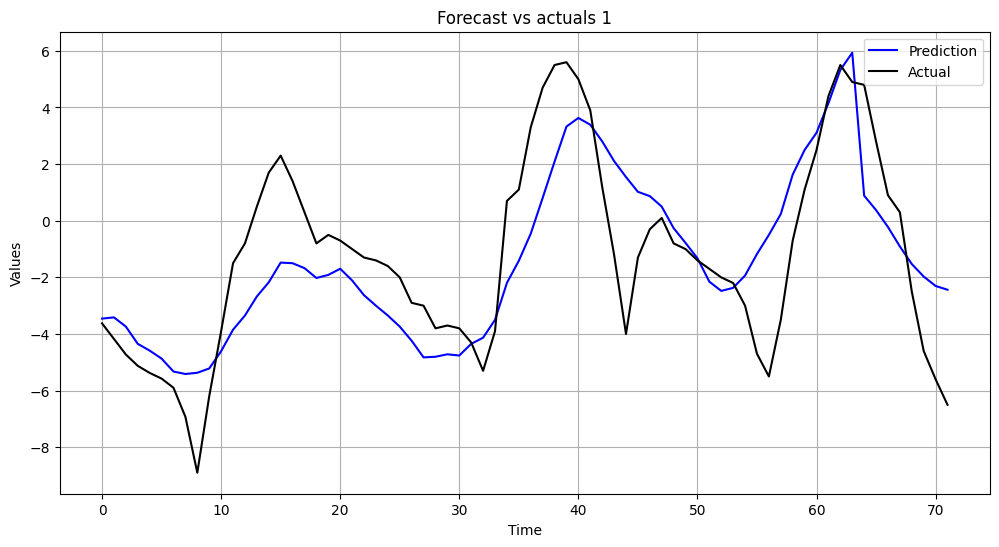

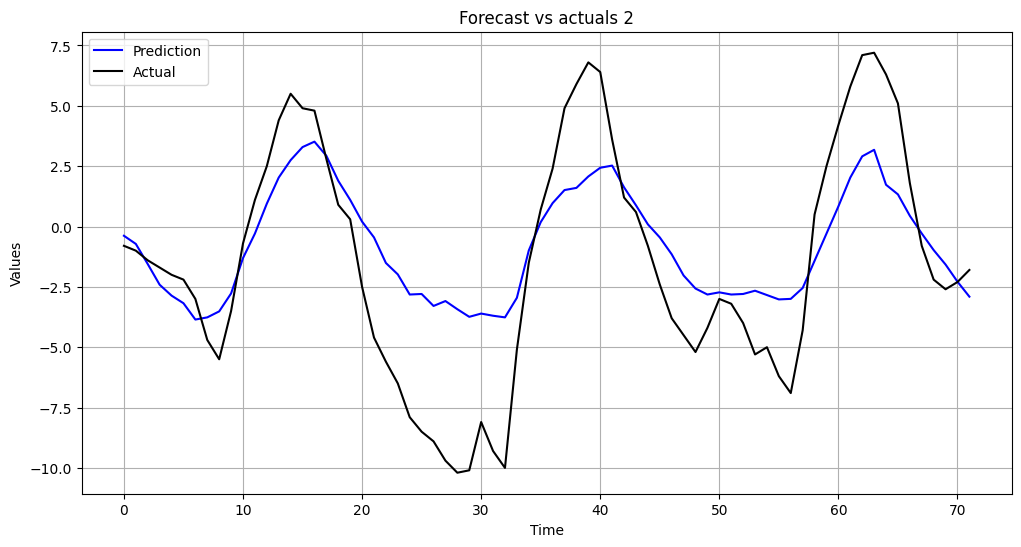

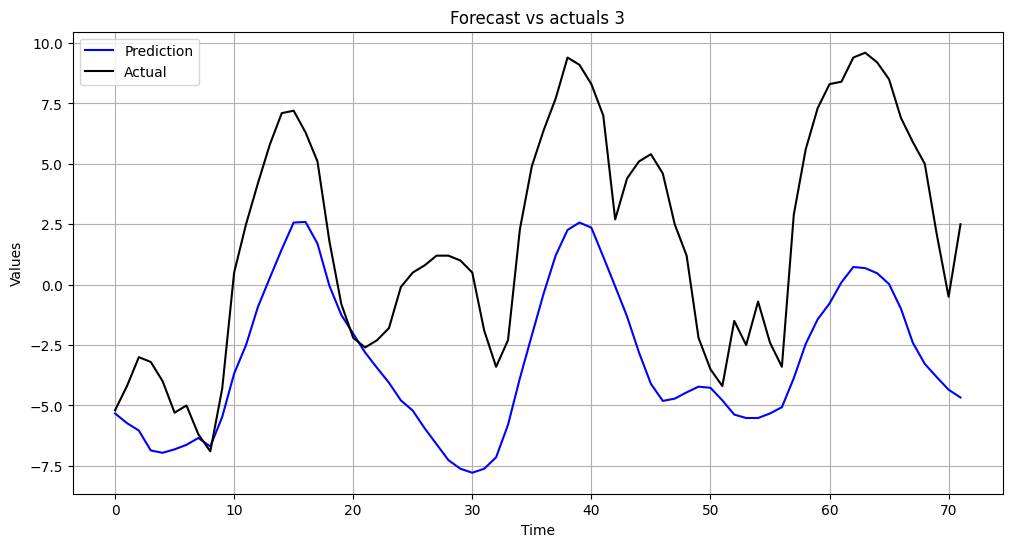

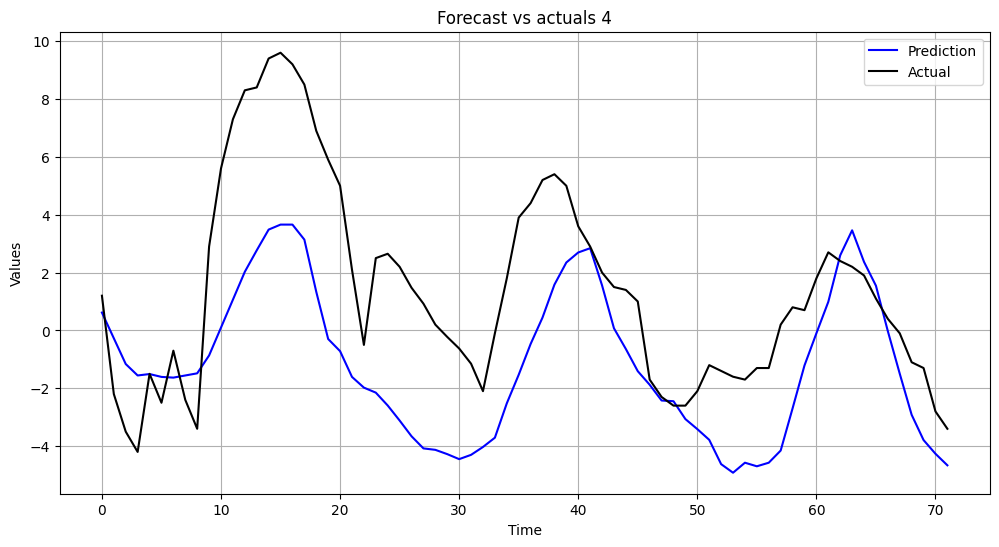

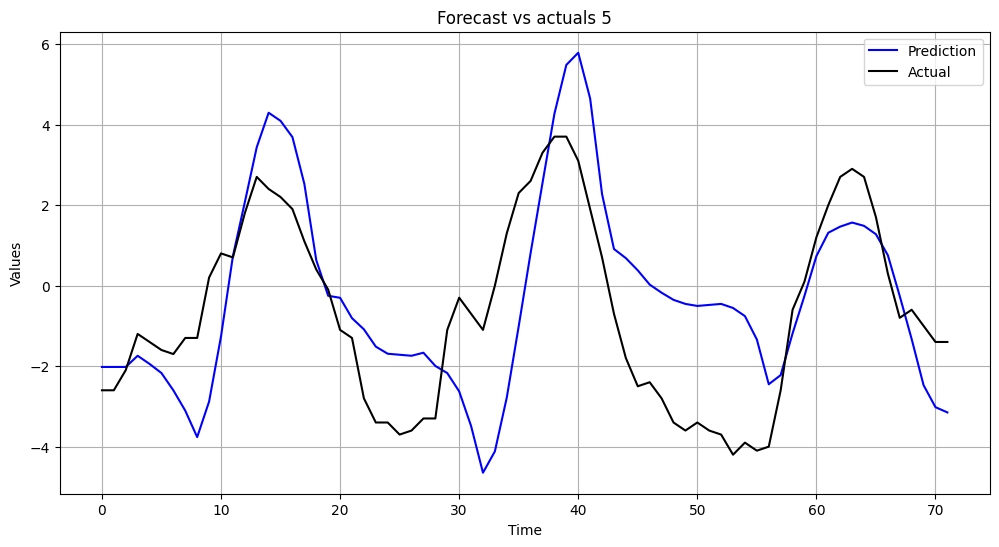

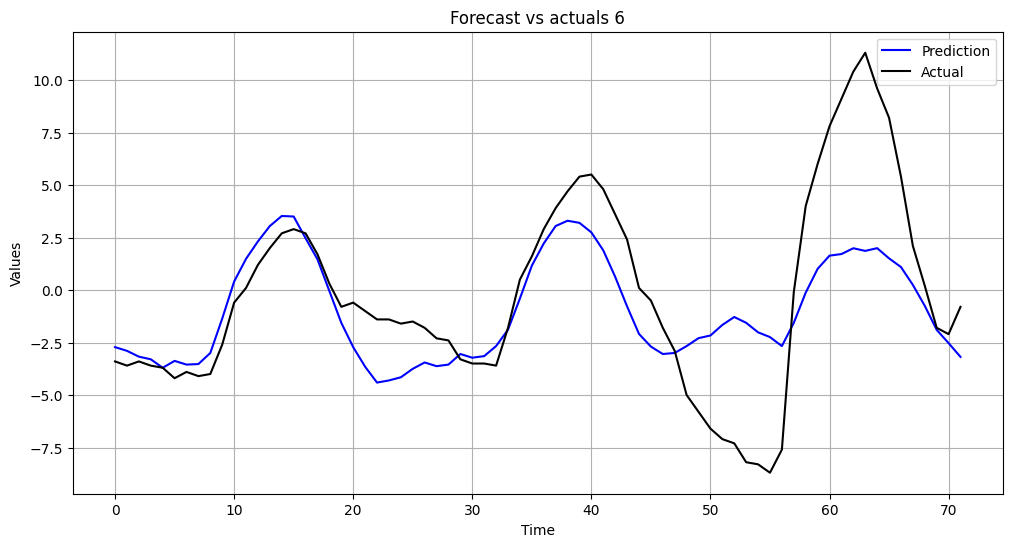

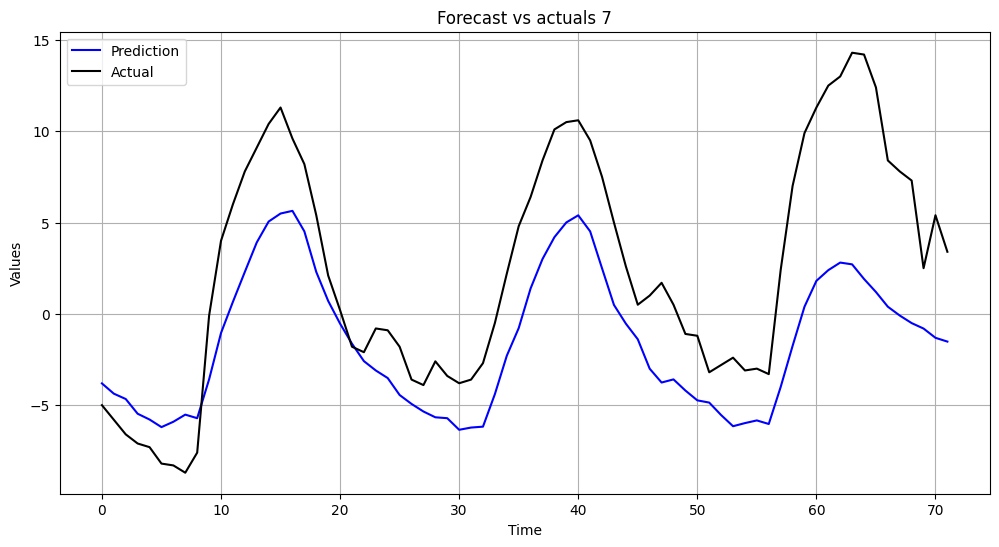

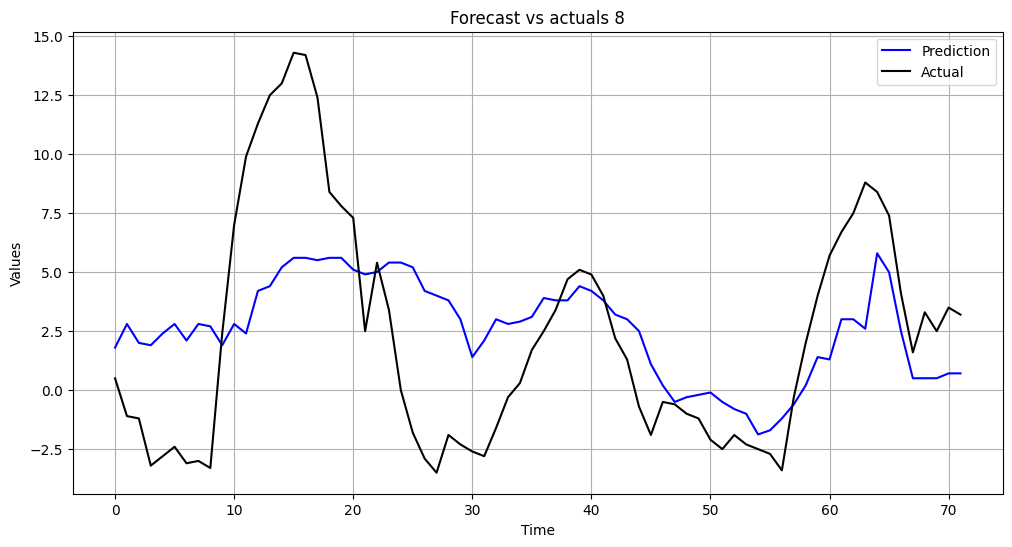

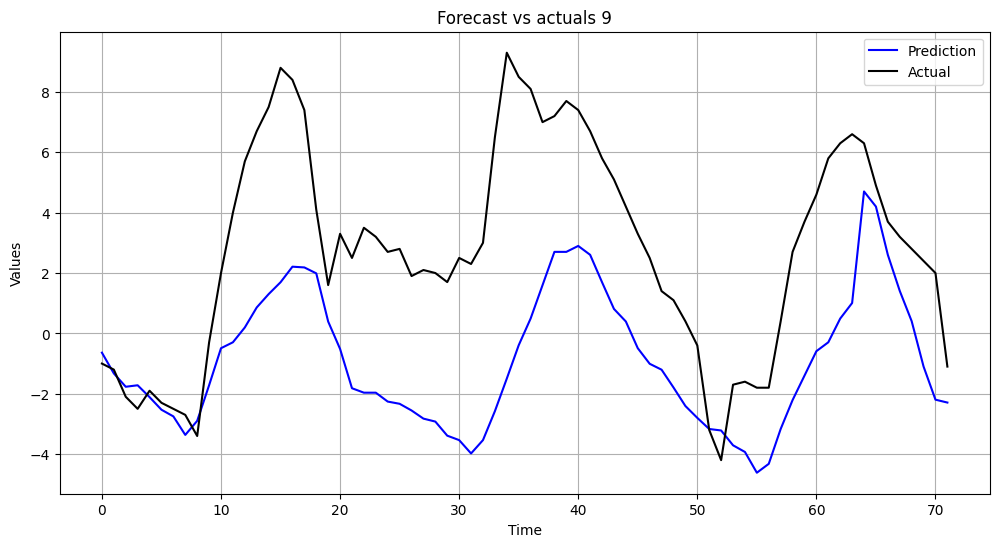

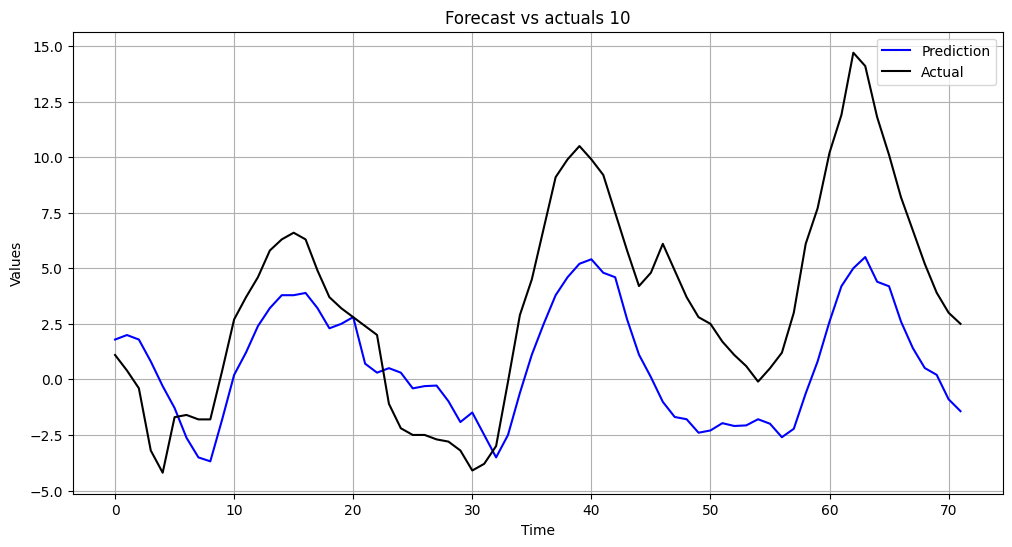

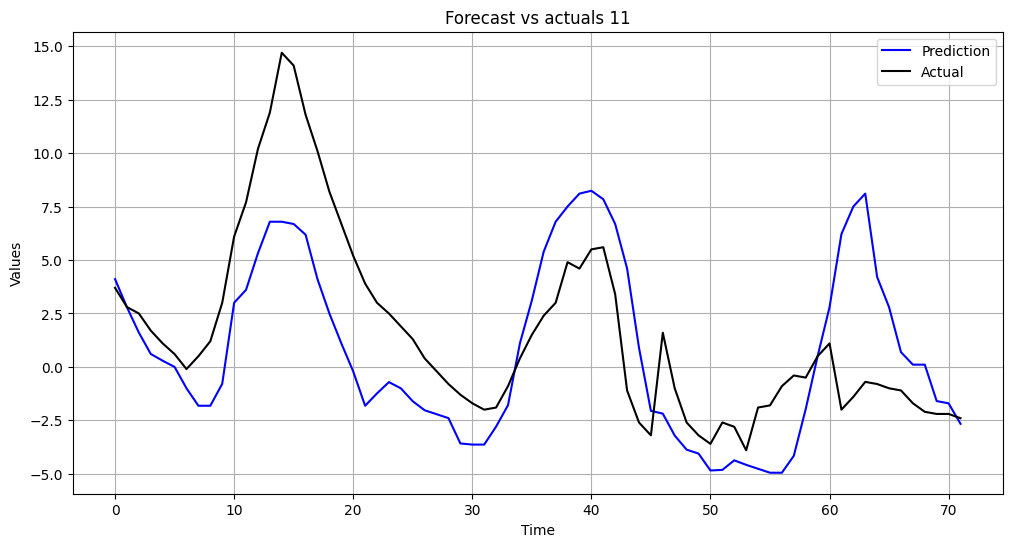

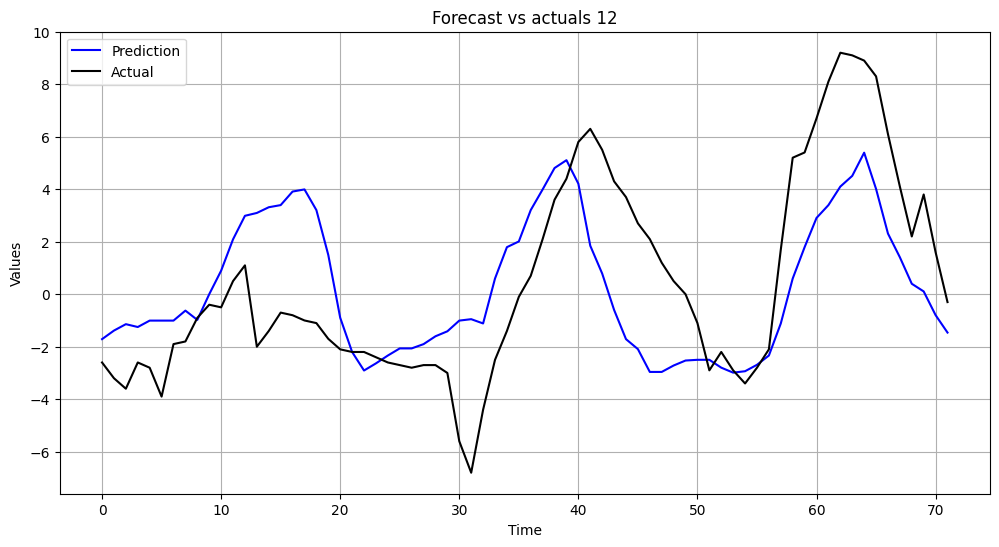

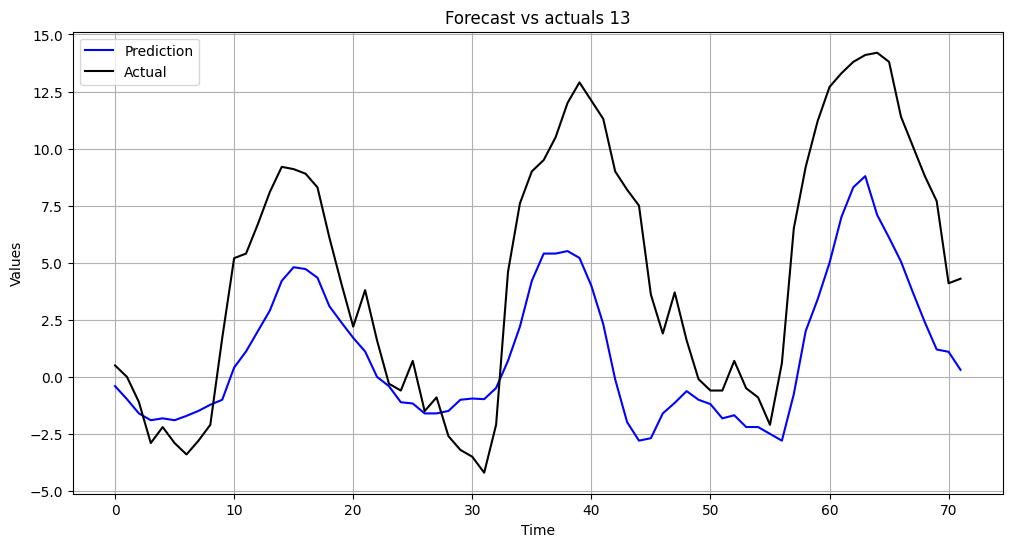

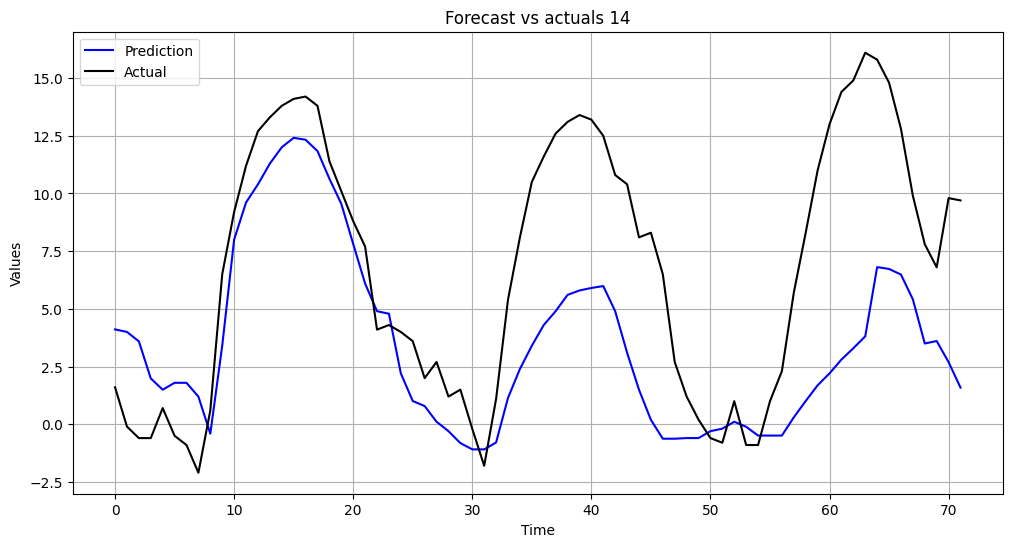

In [ ]:
# Plot the predictions and actual values
for i in range(len(all_predictions)):
  # set figure size
  plt.figure(figsize = (12, 6))

  # predictions
  plt.plot(all_predictions[i], label = "Prediction", color = "blue")
  # actual
  plt.plot(all_actuals[i], label = "Actual", color = "black")

  # set title, legend, and axis
  plt.title(f"Forecast vs actuals {i + 1}")
  plt.ylabel("Values")
  plt.xlabel("Time")
  plt.legend()
  plt.grid(True)
  plt.show()

### Challenge: Improve the function and the data viz

# Parameter Tuning

In [ ]:
import random

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "temperature": [0.1, 0.5, 1.0, 1.5],  # Controls randomness in the predictions
    "top_k": [10, 30, 50, 100],          # Number of top predictions to consider
    "top_p": [0.1, 0.5, 0.75, 1.0],      # Cumulative probability for sampling predictions
    "num_samples": [5, 10, 20, 50]        # Number of samples to draw for each prediction
}

In [ ]:
# Generate all possible combinations of hyperparameters from the grid
param_combinations = list(ParameterGrid(param_grid))

In [ ]:
# Sample a subset of N combinations from the generated list
random.seed(1502)  # Set seed for reproducibility
sampled_combinations = random.sample(param_combinations, 10)  # Sample 10 combinations

sampled_combinations

[{'num_samples': 10, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.75},
 {'num_samples': 50, 'temperature': 1.5, 'top_k': 30, 'top_p': 0.5},
 {'num_samples': 20, 'temperature': 0.1, 'top_k': 30, 'top_p': 1.0},
 {'num_samples': 50, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.1},
 {'num_samples': 20, 'temperature': 1.5, 'top_k': 10, 'top_p': 1.0},
 {'num_samples': 5, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.1},
 {'num_samples': 50, 'temperature': 1.0, 'top_k': 10, 'top_p': 0.1},
 {'num_samples': 20, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.75},
 {'num_samples': 5, 'temperature': 1.5, 'top_k': 50, 'top_p': 0.75},
 {'num_samples': 50, 'temperature': 1.0, 'top_k': 100, 'top_p': 1.0}]

In [ ]:
def time_series_cv_tuning(pipeline, df, forecast_horizon, stride, start_date, end_date, params):
  # Initialize lists to store results, predictions, and actuals
  results = []
  all_predictions = []
  all_actuals = []

  # Set the initial date for the cross-validation loop
  current_date = start_date

  while current_date + pd.Timedelta(hours = forecast_horizon) <= end_date:
    # Split the data into training and test sets
    train = df[df.index < current_date]
    test = df[current_date : current_date + pd.Timedelta(hours = forecast_horizon - 1)]

    # Generate forecasts from the model pipeline
    forecast = pipeline.predict(context = torch.tensor(train.values),
                              temperature = params['temperature'],
                              top_k = params['top_k'],
                              top_p = params['top_p'],
                              prediction_length = forecast_horizon,
                              num_samples = params['num_samples'],
                              limit_prediction_length = False)
    forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim = 0)

    # Store the forecasts and actual values
    all_predictions.append(forecast_mean.numpy())
    all_actuals.append(torch.tensor(test.values).numpy())

    # Calculate the RMSE for the current forecast
    error = np.sqrt(mean_squared_error(torch.tensor(test.values),
                                      forecast_mean))
    print(f"The RMSE is {error}")
    results.append((current_date, error))

    # Move to the next date for the next iteration
    current_date += pd.Timedelta(hours = stride)

  return results, all_predictions, all_actuals

In [ ]:
# Initialize a list to store RMSE results
rmse_results = []

for params in sampled_combinations:
  # Perform cross-validation with the current set of parameters
  results, _, _ = time_series_cv_tuning(pipeline,
                                        df,
                                        forecast_horizon,
                                        stride,
                                        start_date,
                                        end_date,
                                        params)

  # Calculate and store the mean RMSE for the current parameter set
  mean_rmse = np.mean([error for _, error in results])
  rmse_results.append({**params, 'rmse': mean_rmse})

  # Print the RMSE for the current parameter set
  print(f"RMSE for {params}: {mean_rmse}")


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.944759290759982


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.529322411920708


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.843410271085618


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.953344716098765


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.8498637206747615


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.59988426735772


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.308376984479383


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.95585277849779


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.4711779163798604


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.326481378661558


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.212313871728879


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.528210907732421


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.875783884659191


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.065357804077434
RMSE for {'num_samples': 10, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.75}: 3.9617243002938625


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.6425345603728423


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.017613569383037


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.421004059586215


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.339551516461895


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.9010914998687574


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.8620683616578355


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.001915383679464


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.851711052967675


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.316670508506707


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.920171848723996


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.6449119443970246


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.8263510332786534


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.981931706454506


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.668832435451167
RMSE for {'num_samples': 50, 'temperature': 1.5, 'top_k': 30, 'top_p': 0.5}: 4.0283113914849835


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.561824304843964


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.8405944409196624


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.640019111333944


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.088729587713958


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.3311189205359466


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.604132613031489


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 7.15656808656994


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.066203121926182


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.9100010167225685


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.531276046496879


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.1710799736853725


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.0450129610668872


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.524991665165695


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.977882480817504
RMSE for {'num_samples': 20, 'temperature': 0.1, 'top_k': 30, 'top_p': 1.0}: 4.389245309344999


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.8680284839589714


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.9509189882954265


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.842839960589422


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.80306722146969


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.24895439423488


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.918529799426949


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.940443754299336


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.740436151380879


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.910077944577333


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.132269645614787


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.9335159254381797


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.374571417824354


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.566838385286241


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 8.39571807607307
RMSE for {'num_samples': 50, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.1}: 4.401872153462108


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.835781063477345


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.7606274735032197


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.0784715959377085


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.4968267700235627


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.862556792513429


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.032516641728692


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.821191406921399


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.9512144108799423


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.9589881266887836


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.9452305551868245


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.492678957982543


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.1318013360718573


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.841428463206821


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.025909746419738
RMSE for {'num_samples': 20, 'temperature': 1.5, 'top_k': 10, 'top_p': 1.0}: 4.016801667181562


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.870557735933068


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.393184754899172


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.001584690294377


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.6820390251951607


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.540577586365606


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.050681213880095


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.940443754299336


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.740436151380879


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.910077944577333


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.132269645614787


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.9258860445386916


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.1731671137987303


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.566838385286241


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 8.385710739993984
RMSE for {'num_samples': 5, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.1}: 4.165246770432676


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.923400941479816


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.8047848514857607


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.656445872598764


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.9988188989215243


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.8574348277246984


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.606415706189736


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.940443754299336


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.740436151380879


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.910077944577333


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.132269645614787


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.9258860445386916


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.1731671137987303


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.566838385286241


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.068318069968647
RMSE for {'num_samples': 50, 'temperature': 1.0, 'top_k': 10, 'top_p': 0.1}: 4.164624157704639


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.3286097985442713


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.4327832031558128


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.55475965437763


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.344104513939707


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 1.824153550447563


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.004322017477427


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.462634771202839


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.613402494866557


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.755589157942827


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.385188309040724


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.715180167948057


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.352854345161058


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.0079819031862955


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.310959125830346
RMSE for {'num_samples': 20, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.75}: 4.149465929508651


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.303149816300988


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.9027058463904227


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 7.071594355035021


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.7303785103622946


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.099493689320172


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.806470129439432


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 6.523750080721685


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.7167199101490596


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.251004136529244


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.25001808763411


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.96425946477134


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.5182525355196823


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.915867724579425


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.803895779449834
RMSE for {'num_samples': 5, 'temperature': 1.5, 'top_k': 50, 'top_p': 0.75}: 4.418397147585908


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.4464636155853676


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.876847634567468


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 5.529970449454445


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.185602040591067


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 2.4329778385485312


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.863604695015684


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.695360593093111


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.037436292345995


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.458265770716049


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.5600194582903955


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 3.711472400918066


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.757525233908563


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.9327251593679655


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


The RMSE is 4.667467245534885
RMSE for {'num_samples': 50, 'temperature': 1.0, 'top_k': 100, 'top_p': 1.0}: 4.011124173424114


In [ ]:
# Put the result in a DataFrame
rmse_df = pd.DataFrame(rmse_results)
rmse_df

,num_samples,temperature,top_k,top_p,rmse
0,10,0.5,30,0.75,3.961724
1,50,1.5,30,0.50,4.028311
2,20,0.1,30,1.00,4.389245
3,50,0.5,100,0.10,4.401872
4,20,1.5,10,1.00,4.016802
5,5,0.5,30,0.10,4.165247
6,50,1.0,10,0.10,4.164624
7,20,0.5,100,0.75,4.149466
8,5,1.5,50,0.75,4.418397
9,50,1.0,100,1.00,4.011124


In [ ]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = rmse_df.sort_values('rmse').iloc[0]
best_params.to_csv('best_params.csv')

# Predict the future

In [ ]:
# Transform the best parameters into a dictionary
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

{'num_samples': 10.0,
 'temperature': 0.5,
 'top_k': 30.0,
 'top_p': 0.75,
 'rmse': 3.9617243002938625}

In [ ]:
# Build the tuned amazon chronos model
best_forecast = pipeline.predict(
    context = torch.tensor(df.values),  # Provide the entire dataset as context for prediction
    temperature = best_params_dict['temperature'],  # Set the temperature parameter for sampling
    top_k = int(best_params_dict['top_k']),  # Use the top_k parameter to control diversity of predictions
    top_p = best_params_dict['top_p'],  # Use the top_p parameter to control cumulative probability for sampling
    prediction_length = forecast_horizon,  # Specify the number of steps to forecast
    num_samples = int(best_params_dict['num_samples']),  # Define the number of samples for predictions
    limit_prediction_length = False)  # Allow predictions to exceed the default limit if set to False


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [ ]:
# Compute the mean of the forecast across all samples
best_forecast_mean = torch.mean(torch.stack([f[0] for f in best_forecast]), dim = 0)

# Create an index for the forecast that starts immediately after the last index in the df
forecast_index = pd.date_range(start = df.index[-1] + pd.Timedelta(hours = 1),
                               periods = forecast_horizon,
                               freq = "H")

# Create a Pandas Series with the forecast values and index
forecast_series = pd.Series(
    best_forecast_mean.numpy(),  # Convert the tensor to a NumPy array
    index=forecast_index)  # Use the generated forecast index

forecast_series = forecast_series.rename("Amazon Chronos")  # Rename the series for clarity

forecast_series[:2]  # Display the first two values of the forecast

,Amazon Chronos
2017-03-01 00:00:00,5.791227
2017-03-01 01:00:00,5.690218


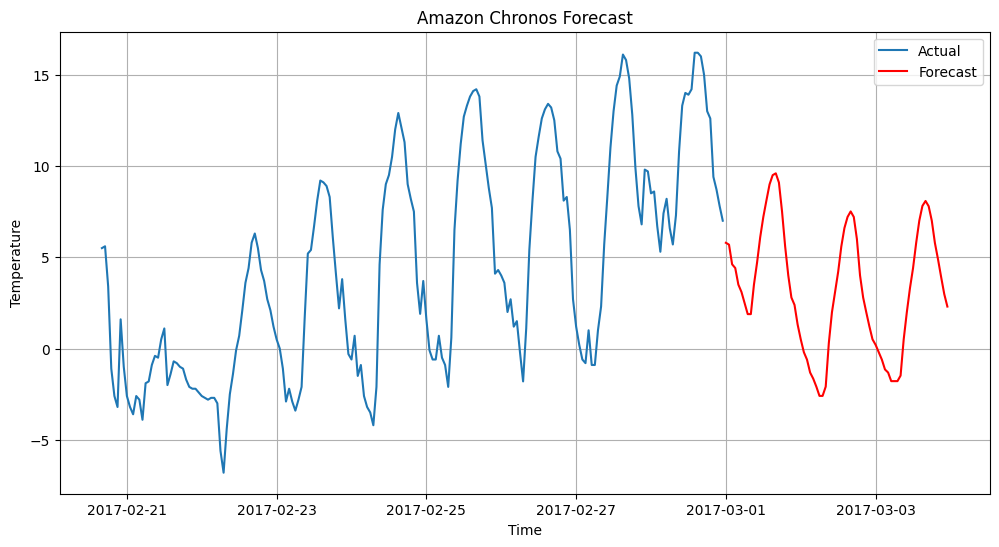

In [ ]:
# Plot the df with the forecast
plt.figure(figsize = (12, 6))

# Actual values
plt.plot(df[-200:], label = "Actual")
# Forecast values
plt.plot(forecast_series, label = "Forecast", color = "red")

# Set title, legend, and labels
plt.title("Amazon Chronos Forecast")
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()